## Feature selection using sisPCA on the Breast Cancer Wisconsin dataset

In this tutorial, we will showcase how sisPCA can be used as a plug-in replacement of PCA to get better disentangled data representation.

In [1]:
import torch
from lightning.pytorch import seed_everything
torch.set_default_dtype(torch.float32)

import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from scipy.linalg import subspace_angles
from plotnine import *

from sispca.utils import normalize_col, delta_kernel, hsic_gaussian, hsic_linear
from sispca import Supervision, SISPCADataset, SISPCA

### Load and preprocess the breast cancer dataset
The [Kaggle Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data?resource=download) contains 569 samples with 30 real-valued summary features calculated from imaging data of breast mass. Here our goals include:

1.	Learn a representation for predicting diagnosis status ('Malignant' or 'Benign', not used during training).
2.	Understand how original features contribute to data variability, the learned representation, and diagnosis potential.

In [2]:
# kaggle datasets download -d uciml/breast-cancer-wisconsin-data
data_raw = pd.read_csv('./data/breast_cancer.csv')
data_raw.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
# remove the id and diagnosis columns
data = data_raw.drop(['Unnamed: 32','id','diagnosis'], axis = 1)

Each one of the 30 features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image, such as radius (mean of distances from center to points on the perimeter), texture (standard deviation of gray-scale values), perimeter and area. Note that the feature set is somewhat redundant. For example, 'perimeter' features are highly correlated with 'radius' features.

In [4]:
torch.corrcoef(
    normalize_col(torch.from_numpy(
        data_raw[['radius_mean', 'perimeter_mean']].to_numpy()
        ), center=True, scale=True).T
)[0][1].item()

0.997855281493811

In [5]:
torch.corrcoef(
    normalize_col(torch.from_numpy(
        data_raw[['radius_mean', 'perimeter_worst']].to_numpy()
        ), center=True, scale=True).T
)[0][1].item()

0.9651365139559879

### Principal component analysis (PCA)
Let us first try the unsupervised PCA to select features that best capture the data. This can be done by running `torch.linalg.svd`, or equivalently, running `SISPCA` with a single unsupervised subspace.

In [6]:
# first normalize the data
x = torch.from_numpy(data.to_numpy()) # (569, 30)
x = normalize_col(x, center=True, scale = True)

# then solve PCA by SVD
u, s, vh = torch.linalg.svd(x, full_matrices=False)
pca_rep_1 = (u @ torch.diag(s)).numpy() # the svd-based pca scores, (569, 30)

In [7]:
# or alternatively, solve PCA as a special case of SISPCA
model = SISPCA(
    SISPCADataset(x, target_supervision_list=[]),
    n_latent_sub = [10],
    solver = 'eig',
)
model.fit(batch_size = -1, max_epochs = 20)
pca_rep_2 = model.get_latent_representation()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: PossibleUserWarning: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:182: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 300    | n/a 
---------------------------------------------
0         Trainable params
300       Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


0 supervision variables provided for 1 subspaces. The last subspace will be unsupervised.


/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: PossibleUserWarning: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

We can see that the two solutions are essentially the same.

In [8]:
np.linalg.norm(subspace_angles(pca_rep_1[:, :10], pca_rep_2[:, :10]))

np.float64(2.679780878067073e-06)

#### Examine variances explained by each PC
To determine the number of PCs to include, we can check the elbow of the variance explained curve.

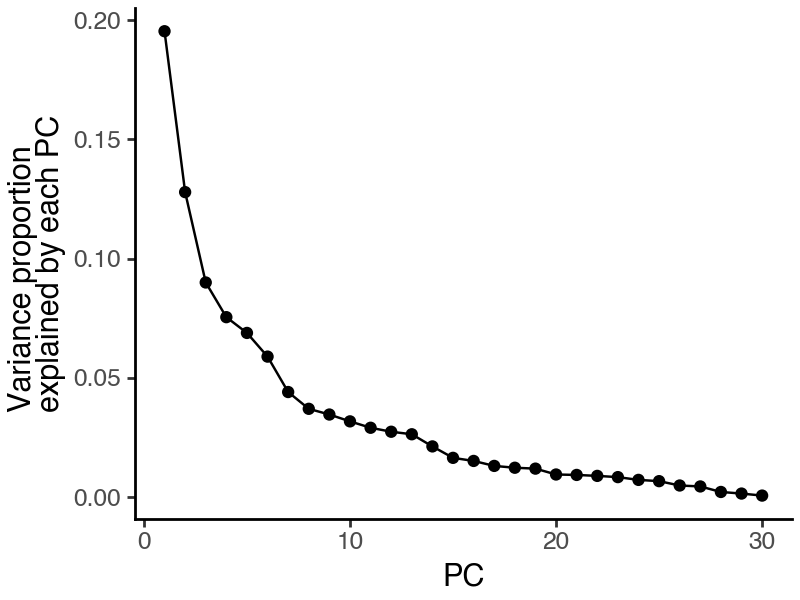

In [9]:
df_var = pd.DataFrame({
    'pc': np.arange(len(s)) + 1,
    'var_explained_ratio': (s / s.sum()).numpy()
})

(
    ggplot(df_var, aes(x = 'pc', y = 'var_explained_ratio')) + 
        geom_point() + 
        geom_line() + 
        labs(x = 'PC', y = 'Variance proportion\nexplained by each PC') + 
        theme_classic() + 
        theme(figure_size=(4,3))
)

In [10]:
n_dim = 6
print(f"The top {n_dim} PCs collectively explain {s[:n_dim].sum() / s.sum() * 100 :.1f}% of total variance.")

The top 6 PCs collectively explain 61.6% of total variance.


#### Visualize and quantify the quality of PCA representations
From the plot, it appears that the malignant and benign samples are well separated according to PC1 and PC2, while there is also strong within-group variation.

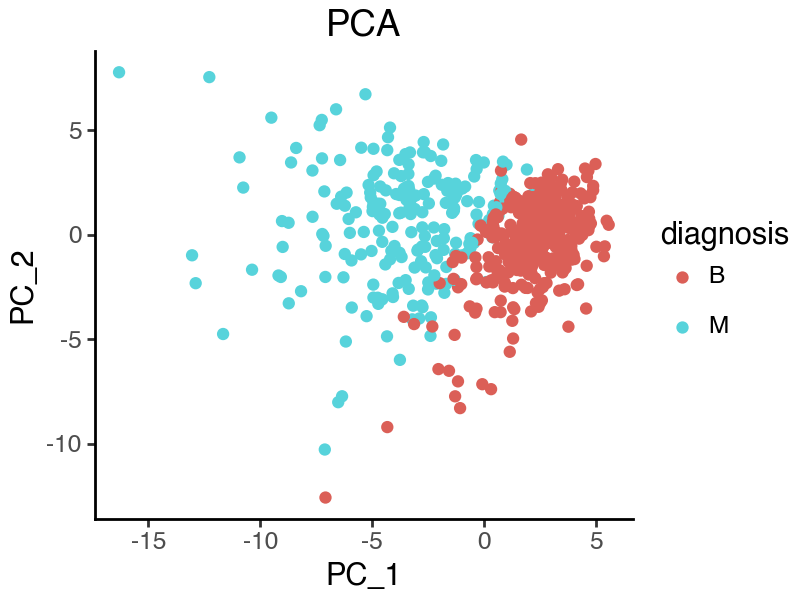

In [11]:
df_sample = data_raw.copy()
df_sample['PC_1'] = pca_rep_1[:, 0]
df_sample['PC_2'] = pca_rep_1[:, 1]

(
    ggplot(df_sample, aes(x = 'PC_1', y = 'PC_2')) + 
        geom_point(aes(color = 'diagnosis')) + 
        labs(title = 'PCA') + 
        theme_classic() + 
        theme(figure_size=(4,3))
)

To quantitatively evaluate the quality of our representation, we can measure the prediction power regarding malignancy status using the Sihouette score. A higher score means that malignant and benign samples are more separated in the corresponding latent space.

In [12]:
print(f"Silhouette score (PCA - PC1-3) {silhouette_score(u[:, :3], data_raw['diagnosis']):.3f}")
print(f"Silhouette score (PCA - PC4-6) {silhouette_score(u[:, 3:6], data_raw['diagnosis']):.3f}")
print(f"Silhouette score (PCA - PC1-6) {silhouette_score(u[:, :6], data_raw['diagnosis']):.3f}")

Silhouette score (PCA - PC1-3) 0.294
Silhouette score (PCA - PC4-6) 0.013
Silhouette score (PCA - PC1-6) 0.160


#### Extract top features that contribute to PC1
Using the PCA loading matrix, we can rank features based on their contributions to each PC. Here, we focus on the first PC where malignant and benign samples are best separated. From the above plot, it is clear that malignancy-specific features should contribute *negatively* to PC1.

In [13]:
df_project = pd.DataFrame({
    'name': data.columns,
    'loading_pc1': vh[:, 0].numpy(),
    'loading_pc2': vh[:, 1].numpy(),
    'loading_pc3': vh[:, 2].numpy(),
})
df_project.sort_values('loading_pc1', ascending=True).head()

,name,loading_pc1,loading_pc2,loading_pc3
8,symmetry_mean,-0.223110,0.112699,-0.223739
0,radius_mean,-0.218902,-0.103725,-0.227537
23,area_worst,-0.182579,0.098787,-0.116649
15,compactness_se,-0.150584,-0.157842,-0.114454
26,concavity_worst,-0.131527,-0.017357,-0.115415


Let's visualize the top 2 features, namely 'symmetry_mean' and 'radius_mean'.

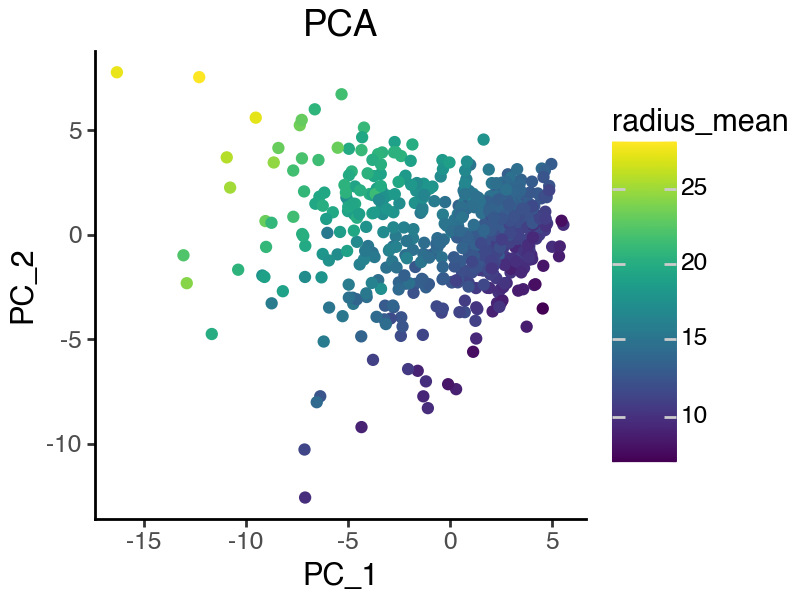

In [14]:
(
    ggplot(df_sample, aes(x = 'PC_1', y = 'PC_2')) + 
        geom_point(aes(color = 'radius_mean')) + 
        labs(title = 'PCA') + 
        theme_classic() + 
        theme(figure_size=(4,3))
)

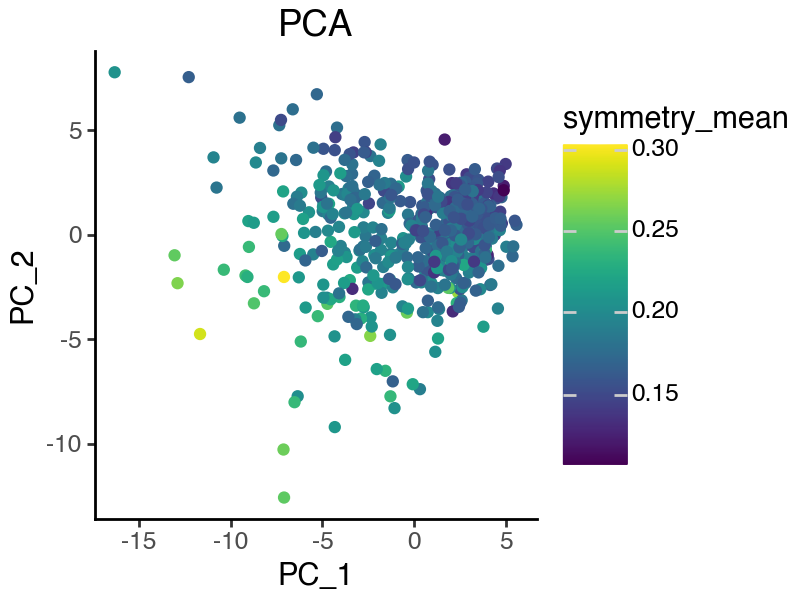

In [15]:
(
    ggplot(df_sample, aes(x = 'PC_1', y = 'PC_2')) + 
        geom_point(aes(color = 'symmetry_mean')) + 
        labs(title = 'PCA') + 
        theme_classic() + 
        theme(figure_size=(4,3))
)

### Supervised PCA (sPCA)
In practice, we often want to build representations that reflect specific aspects of the data. For example, the two top contributors to PC1, 'symmetry_mean' and 'radius_mean', each represents different quantities ("shape" vs "size" of the cell nucleus, respectively). [sPCA (Barshan, Elnaz, et al.)](https://www.sciencedirect.com/science/article/pii/S0031320310005819) extends PCA by allowing us to provide supervision information to guide the learning of the desired latent space.

#### Model fitting
We can again fit the sPCA model as a special case of `SISPCA` with a single supervised subspace. To do that, we will first need to create a `SISPCADataset` object that contains the data and the supervision information.

In [16]:
# select the target variables for each subspace
y_radius = normalize_col(torch.from_numpy(
    data[['radius_mean', 'radius_se']].to_numpy()
), center=True, scale=True)
y_sym = normalize_col(torch.from_numpy(
    data[['symmetry_mean', 'symmetry_se']].to_numpy()
), center=True, scale=True)

# remove the target variables from the data
data_sub = data.drop(
    ['radius_mean', 'radius_se',
    'symmetry_mean', 'symmetry_se',], 
    axis = 1
)
x_sub = normalize_col(torch.from_numpy(data_sub.to_numpy()), center=True, scale=True)

# prepare the model inputs
sdata = SISPCADataset(
    data = x_sub.float(),
    target_supervision_list = [
        Supervision(target_data=y_radius, target_type='continuous', target_name='radius'),
        Supervision(target_data=y_sym, target_type='continuous', target_name='symmetry'),
    ]
)

The first subspace is the radius subspace, and the second is the symmetry subspace. Here we use linear kernel for both subspaces since the supervisions are continuous. Each subspace has an effective dimension of 2, since the rank of target kernel (Y.T @ Y) is 2. 

In [17]:
print(f"The radius subspace has {sdata.target_kernel_list[0].rank()} effective dimensions.")
print(f"The symmetry subspace has {sdata.target_kernel_list[1].rank()} effective dimensions.")

The radius subspace has 2 effective dimensions.
The symmetry subspace has 2 effective dimensions.


Now let's run the model fitting based on pytorch lightning.

In [18]:
# each subspace will have dimension 3
n_latent_sub = [3, 3]
lambda_contrast = 0
kernel_subspace = 'linear'
solver = 'eig'

seed_everything(42, workers=True)

spca = SISPCA(
    sdata, 
    n_latent_sub=n_latent_sub, 
    lambda_contrast=lambda_contrast,
    kernel_subspace=kernel_subspace,
    solver=solver
)
spca.fit(batch_size = -1, max_epochs = 5)

Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: PossibleUserWarning: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:182: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pyt

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


#### Visualize and quantify the quality of sPCA representations

The 'radius' and 'symmetry' subspaces are concatenated together after training.

In [19]:
spca_rep = spca.get_latent_representation()

df_sample = data_raw.copy()
df_sample['PC_radius_1'] = spca_rep[:, 0]
df_sample['PC_radius_2'] = spca_rep[:, 1]
df_sample['PC_sym_1'] = spca_rep[:, 3]
df_sample['PC_sym_2'] = spca_rep[:, 4]

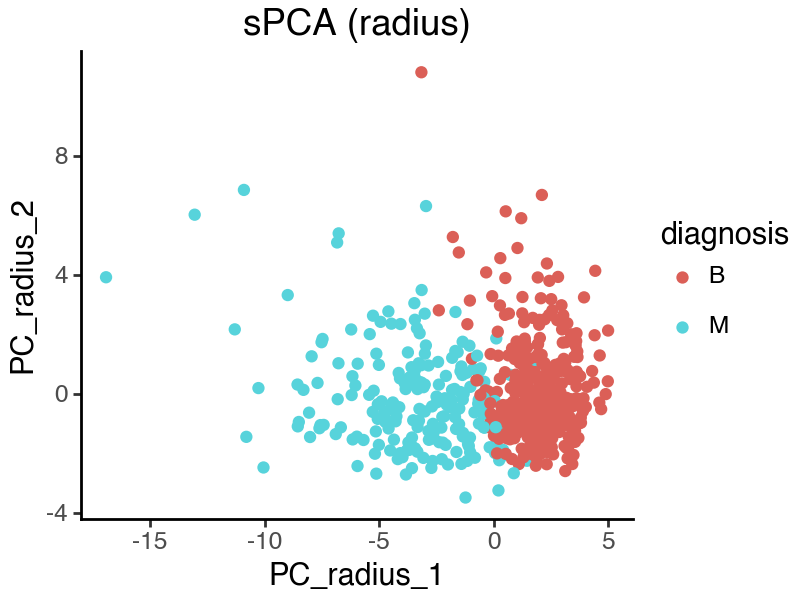

In [20]:
(
    ggplot(df_sample, aes(x = 'PC_radius_1', y = 'PC_radius_2')) + 
        geom_point(aes(color = 'diagnosis')) + 
        labs(title = 'sPCA (radius)') + 
        theme_classic() + 
        theme(figure_size=(4,3))
)

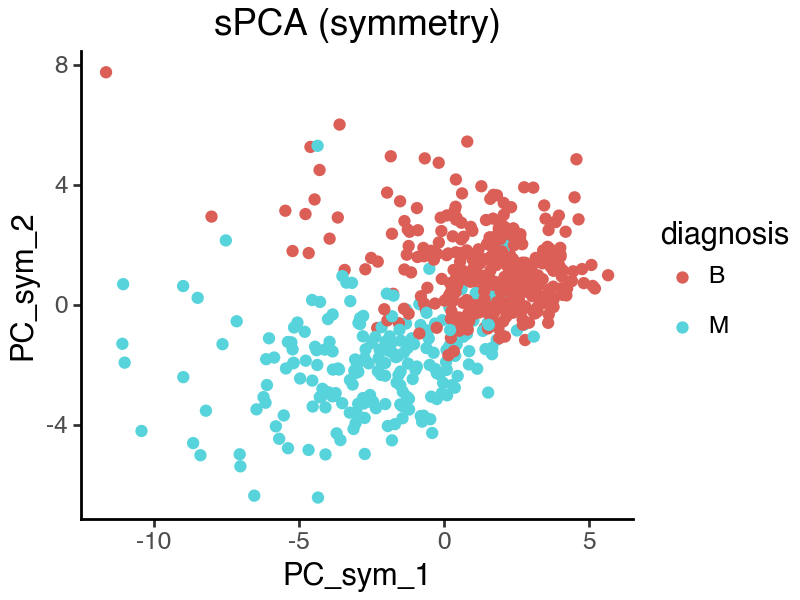

In [21]:
(
    ggplot(df_sample, aes(x = 'PC_sym_1', y = 'PC_sym_2')) + 
        geom_point(aes(color = 'diagnosis')) + 
        labs(title = 'sPCA (symmetry)') + 
        theme_classic() + 
        theme(figure_size=(4,3))
)

From the above sPCA plots, both subspaces seem to contain sample variations related to disease status. 
We can further quantify the observation by calculating the silhouette scores.

In [22]:
print(f"Silhouette score (sPCA - radius) {silhouette_score(spca_rep[:, :3], data_raw['diagnosis']):.3f}")
print(f"Silhouette score (sPCA - symmetry) {silhouette_score(spca_rep[:, 3:6], data_raw['diagnosis']):.3f}")
print(f"Silhouette score (sPCA - overall) {silhouette_score(spca_rep[:, :6], data_raw['diagnosis']):.3f}")

Silhouette score (sPCA - radius) 0.471
Silhouette score (sPCA - symmetry) 0.407
Silhouette score (sPCA - overall) 0.437


#### Extract top features that contribute to each subspace

Now we can look at the top features that contribute to each subspace. Because we did not explicitly ask the two subspaces to be disentangled, the two spaces still capture overlapping information even under distinct supervision. For example, the PC2 loadings of the two subspaces are highly correlated.

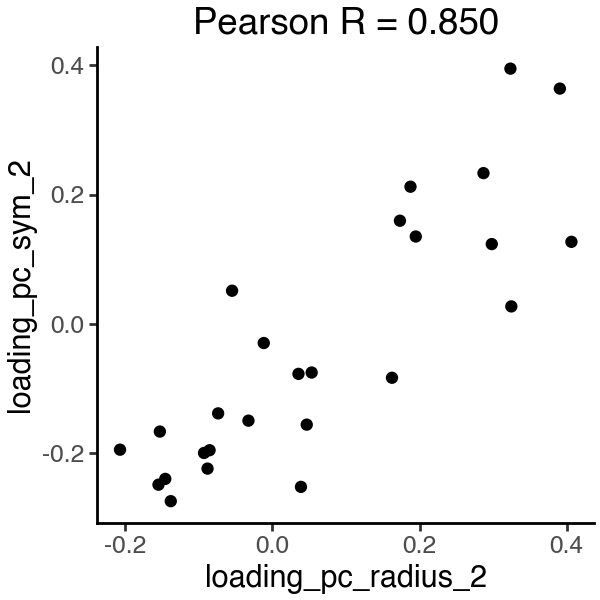

In [23]:
vh = spca.U.detach()

df_project = pd.DataFrame({
    'name': data_sub.columns,
    'loading_pc_radius_1': vh[:, 0].numpy(),
    'loading_pc_radius_2': vh[:, 1].numpy(),
    'loading_pc_sym_1': vh[:, 3].numpy(),
    'loading_pc_sym_2': vh[:, 4].numpy(),
})

(
    ggplot(df_project, aes(x = 'loading_pc_radius_2', y = 'loading_pc_sym_2')) + 
        geom_point() + 
        # geom_text(aes(label = 'name')) + 
        labs(title = f"Pearson R = {np.corrcoef(vh[:, 1].numpy(), vh[:, 4].numpy())[0][1]:.3f}") + 
        theme_classic() + 
        theme(figure_size=(3,3))
)

In the PC2 loadings, we see that 'smoothness_se' strongly contributes to both subspaces, which may not be ideal.

In [24]:
df_project.sort_values('loading_pc_radius_2', ascending=False, key = abs).head()

,name,loading_pc_radius_1,loading_pc_radius_2,loading_pc_sym_1,loading_pc_sym_2
9,perimeter_se,-0.294413,0.406375,-0.187506,0.126918
11,smoothness_se,0.014764,0.390662,-0.164616,0.363588
10,area_se,-0.302685,0.324720,-0.122182,0.027174
8,texture_se,-0.017534,0.323500,-0.139245,0.394407
7,fractal_dimension_mean,0.059744,0.298165,-0.273750,0.123427


In [25]:
df_project.sort_values('loading_pc_sym_2', ascending=False, key = abs).head()

,name,loading_pc_radius_1,loading_pc_radius_2,loading_pc_sym_1,loading_pc_sym_2
8,texture_se,-0.017534,0.323500,-0.139245,0.394407
11,smoothness_se,0.014764,0.390662,-0.164616,0.363588
23,concave points_worst,-0.232865,-0.137929,-0.175061,-0.273636
20,smoothness_worst,-0.047029,0.038949,-0.177212,-0.251543
16,radius_worst,-0.307310,-0.154605,-0.051738,-0.248183


We can also directly quantify subspace entanglement using the Grassmann distance or the HSIC statistics. The higher/lower the distance/HSIC, the more disentangled the subspaces are.

In [26]:
# subspace grassmann distance
_dist = np.linalg.norm(subspace_angles(
    spca_rep[:, :3], 
    spca_rep[:, 3:6]
))

_hsic = hsic_linear(
    torch.from_numpy(spca_rep[:, :3]), 
    torch.from_numpy(spca_rep[:, 3:6])
)
print(f"Subspace distance {_dist:.3f}, HSIC-linear {_hsic:.3f}")

Subspace distance 1.321, HSIC-linear 105.829


### Supervised independent subspace PCA (sisPCA)
Now we introduce sisPCA, a multi-subspace extension of PCA and sPCA that incorporates an HSIC-based disentanglement penalty to further encourage subspace separation.

#### Model fitting

We again define two subspaces to focus on two image properties, the 'radius' subspace for nuclei size, and the 'symmetry' subspace for nuclei shape.

In [27]:
# select the target variables for each subspace
y_radius = normalize_col(torch.from_numpy(
    data[['radius_mean', 'radius_se']].to_numpy()
), center=True, scale=True)
y_sym = normalize_col(torch.from_numpy(
    data[['symmetry_mean', 'symmetry_se']].to_numpy()
), center=True, scale=True)

# remove the target variables from the data
data_sub = data.drop(
    ['radius_mean', 'radius_se',
    'symmetry_mean', 'symmetry_se',], 
    axis = 1
)
x_sub = normalize_col(torch.from_numpy(data_sub.to_numpy()), center=True, scale=True)

# prepare the model inputs
sdata = SISPCADataset(
    data = x_sub.float(),
    target_supervision_list = [
        Supervision(target_data=y_radius, target_type='continuous', target_name='radius'),
        Supervision(target_data=y_sym, target_type='continuous', target_name='symmetry'),
    ]
)

When running sisPCA, the hyperparameter `lambda_contrast` controls the strength of the disentanglement penalty. We will discuss the tuning of this parameter in the final section.

In [28]:
n_latent_sub = [3, 3]
lambda_contrast = 10
kernel_subspace = 'linear'
solver = 'eig'

seed_everything(42, workers=True)

sispca = SISPCA(
    sdata, 
    n_latent_sub=n_latent_sub, 
    lambda_contrast=lambda_contrast,
    kernel_subspace=kernel_subspace,
    solver=solver
)
sispca.fit(batch_size = -1, max_epochs = 100, early_stopping_patience = 5)

Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: PossibleUserWarning: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:182: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pyt

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


#### Visualize and quantify the quality of sisPCA representations

In [29]:
sispca_rep = sispca.get_latent_representation()

df_sample = data_raw.copy()
df_sample['PC_radius_1'] = sispca_rep[:, 0]
df_sample['PC_radius_2'] = sispca_rep[:, 1]
df_sample['PC_sym_1'] = sispca_rep[:, 3]
df_sample['PC_sym_2'] = sispca_rep[:, 4]

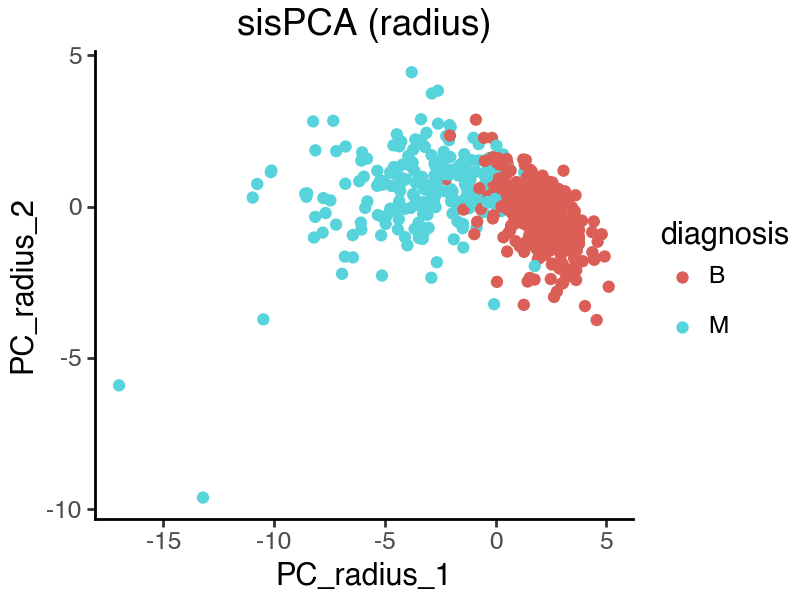

In [30]:
(
    ggplot(df_sample, aes(x = 'PC_radius_1', y = 'PC_radius_2')) + 
        geom_point(aes(color = 'diagnosis')) + 
        labs(title = 'sisPCA (radius)') + 
        theme_classic() + 
        theme(figure_size=(4,3))
)

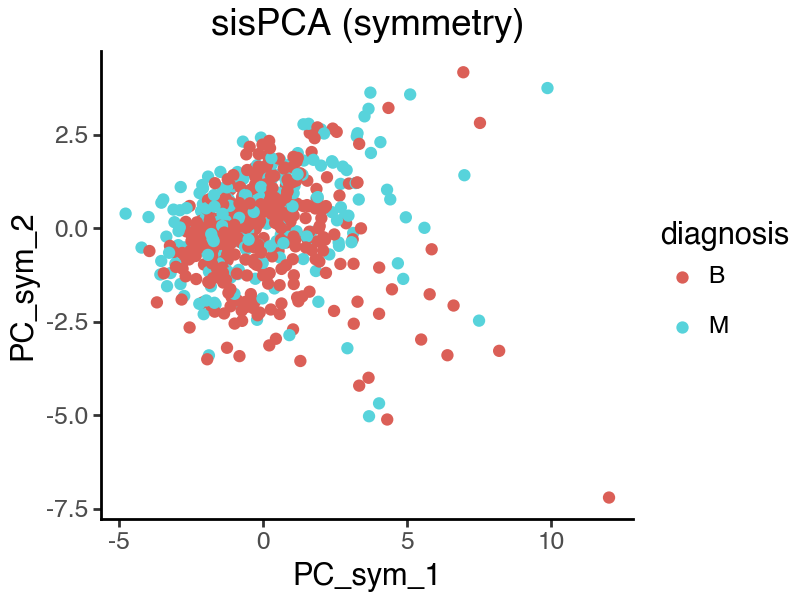

In [31]:
(
    ggplot(df_sample, aes(x = 'PC_sym_1', y = 'PC_sym_2')) + 
        geom_point(aes(color = 'diagnosis')) + 
        labs(title = 'sisPCA (symmetry)') + 
        theme_classic() + 
        theme(figure_size=(4,3))
)

In [32]:
print(f"Silhouette score (sisPCA - radius) {silhouette_score(sispca_rep[:, :3], data_raw['diagnosis']):.3f}")
print(f"Silhouette score (sisPCA - symmetry) {silhouette_score(sispca_rep[:, 3:6], data_raw['diagnosis']):.3f}")
print(f"Silhouette score (sisPCA - overall) {silhouette_score(sispca_rep[:, :6], data_raw['diagnosis']):.3f}")

Silhouette score (sisPCA - radius) 0.521
Silhouette score (sisPCA - symmetry) 0.033
Silhouette score (sisPCA - overall) 0.371


We see that in the above sisPCA results, the 'radius' subspace remains predictive, while the 'symmetry' subspace no longer captures difference in disease status. This indeed reflects the true predictive power of the target variables. Note also that by allowing additional information to contribute to the 'radius' subspace, it is now containing more malignancy information than the raw supervision target variable ['radius_mean', 'radius_se'].

In [33]:
_ft = ['radius_mean', 'radius_se']
print(f"Silhouette score ({_ft}) {silhouette_score(data[_ft], data_raw['diagnosis']):.3f}")

Silhouette score (['radius_mean', 'radius_se']) 0.457


In [34]:
_ft = ['symmetry_mean', 'symmetry_se']
print(f"Silhouette score ({_ft}) {silhouette_score(data[_ft], data_raw['diagnosis']):.3f}")

Silhouette score (['symmetry_mean', 'symmetry_se']) 0.092


#### Extract top features that contributes to each subspace

In [35]:
vh = sispca.U.detach()

df_project = pd.DataFrame({
    'name': data_sub.columns,
    'loading_pc_radius_1': vh[:, 0].numpy(),
    'loading_pc_radius_2': vh[:, 1].numpy(),
    'loading_pc_sym_1': vh[:, 3].numpy(),
    'loading_pc_sym_2': vh[:, 4].numpy(),
})

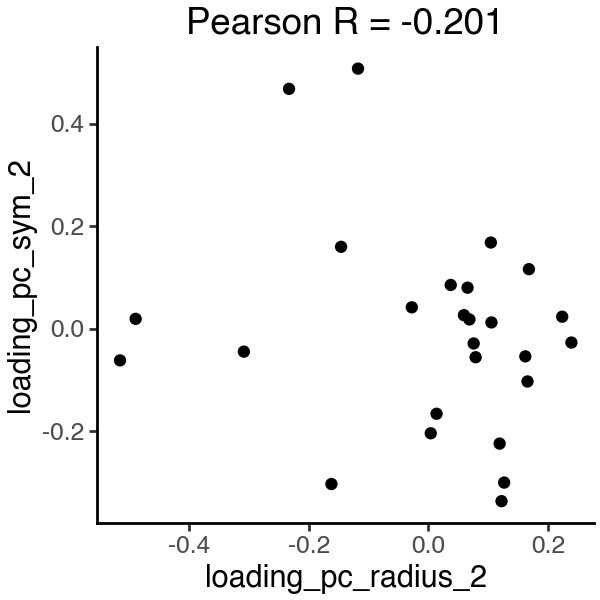

In [36]:
(
    ggplot(df_project, aes(x = 'loading_pc_radius_2', y = 'loading_pc_sym_2')) + 
        geom_point() + 
        # geom_text(aes(label = 'name')) + 
        labs(title = f"Pearson R = {np.corrcoef(vh[:, 1].numpy(), vh[:, 4].numpy())[0][1]:.3f}") + 
        theme_classic() + 
        theme(figure_size=(3,3))
)

Now the PC2 loadings are no longer correlated, and each subspace is constructed from distinct features that are more relevant to the target variables, i.e. 'area_' for the 'radius' subspace and 'smoothness_' for the 'symmetry' subspace.

In [37]:
df_project.sort_values('loading_pc_radius_1', ascending=False, key = abs).head()

,name,loading_pc_radius_1,loading_pc_radius_2,loading_pc_sym_1,loading_pc_sym_2
2,area_mean,-0.323873,0.079059,-0.196451,-0.055753
1,perimeter_mean,-0.317973,0.162154,-0.186226,-0.054114
19,area_worst,-0.317266,-0.027713,-0.201404,0.041665
16,radius_worst,-0.316681,0.059447,-0.205232,0.026357
18,perimeter_worst,-0.315147,0.068681,-0.183593,0.017961


In [38]:
df_project.sort_values('loading_pc_sym_1', ascending=False, key = abs).head()

,name,loading_pc_radius_1,loading_pc_radius_2,loading_pc_sym_1,loading_pc_sym_2
24,symmetry_worst,-0.035552,0.105500,0.423216,0.012136
7,fractal_dimension_mean,0.085793,-0.145951,0.372799,0.159669
11,smoothness_se,0.030047,-0.308551,0.267046,-0.044819
15,fractal_dimension_se,-0.009894,0.003989,0.261434,-0.204098
12,compactness_se,-0.081300,0.122348,0.249812,-0.336611


In [39]:
df_project.sort_values('loading_pc_radius_2', ascending=False, key = abs).head()

,name,loading_pc_radius_1,loading_pc_radius_2,loading_pc_sym_1,loading_pc_sym_2
9,perimeter_se,-0.294218,-0.515662,0.044653,-0.061888
10,area_se,-0.306857,-0.489507,-0.055998,0.019116
11,smoothness_se,0.030047,-0.308551,0.267046,-0.044819
22,concavity_worst,-0.155004,0.239243,0.040021,-0.027116
3,smoothness_mean,-0.066986,-0.233024,0.246799,0.467927


In [40]:
df_project.sort_values('loading_pc_sym_2', ascending=False, key = abs).head()

,name,loading_pc_radius_1,loading_pc_radius_2,loading_pc_sym_1,loading_pc_sym_2
20,smoothness_worst,-0.031913,-0.117651,0.110923,0.507345
3,smoothness_mean,-0.066986,-0.233024,0.246799,0.467927
12,compactness_se,-0.081300,0.122348,0.249812,-0.336611
8,texture_se,-0.010335,-0.162091,0.222898,-0.303128
13,concavity_se,-0.077843,0.126739,0.185260,-0.300306


In [41]:
# subspace grassmann distance
_dist = np.linalg.norm(subspace_angles(
    sispca_rep[:, :3], 
    sispca_rep[:, 3:6]
))

_hsic = hsic_linear(
    torch.from_numpy(sispca_rep[:, :3]), 
    torch.from_numpy(sispca_rep[:, 3:6])
)
print(f"Subspace distance {_dist:.3f}, HSIC-linear {_hsic:.3f}")

Subspace distance 2.710, HSIC-linear 0.002


### Automatic hyperparameter tuning for sisPCA (experimental)
In this section, we will demonstrate how to automatically tune the hyperparameter `lambda_contrast` using spectral clustering.

In [42]:
from sispca.model import SISPCAAuto

#### Subspace ordering
When the target variables are not "balanced", i.e., they may be on different scales or have different kernel configurations, the sisPCA solution may not be globally optimal. Fortunately, this can be resolved by re-ordering the subspaces during the iterative eigendecomposition process. The path towards the global optimum is the one that has the lowest loss after the first few iterations.

In [43]:
seed_everything(42, workers=True)

n_latent_sub = [3, 3]
lambda_contrast = 10
kernel_subspace = 'linear'
solver = 'eig'

sispca_auto = SISPCAAuto(
    sdata, 
    n_latent_sub=n_latent_sub, 
    max_log_lambda_c = 2, # maxmium log10(lambda_contrast)
    n_lambda = 20, # number of lambda_contrast values to search
    n_lambda_clu = 3, # number of lambda_contrast clusters to return
    kernel_subspace=kernel_subspace,
    solver=solver
)

sispca_auto.find_best_update_order()

Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: PossibleUserWarning: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:182: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pyt

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Best subspace order: (1, 0)


In [44]:
print(sispca_auto.dataset.target_name_list)

['symmetry', 'radius']


#### Selecting the best `lambda_contrast`

In [45]:
seed_everything(42, workers=True)

n_latent_sub = [3, 3]
lambda_contrast = 10
kernel_subspace = 'linear'
solver = 'eig'

sispca_auto = SISPCAAuto(
    sdata, 
    n_latent_sub=n_latent_sub, 
    max_log_lambda_c = 2, # maxmium log10(lambda_contrast)
    n_lambda = 20, # number of lambda_contrast values to search
    n_lambda_clu = 3, # number of lambda_contrast clusters to return
    kernel_subspace=kernel_subspace,
    solver=solver
)

sispca_auto.fit(batch_size = -1, max_epochs = 100, early_stopping_patience = 10)

Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 156    | n/a 
---------------------------------------------
0         Trainable params
156       Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Let's visualize the affinity matrix of model fittings with different lambdas and the loss curve.

In [46]:
sispca_auto.create_affinity_matrix(affinity_metric='determinant')
sispca_auto.find_spectral_lambdas()
sispca_auto.lambda_contrast_clusters

array([0, 3, 3, 3, 3, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

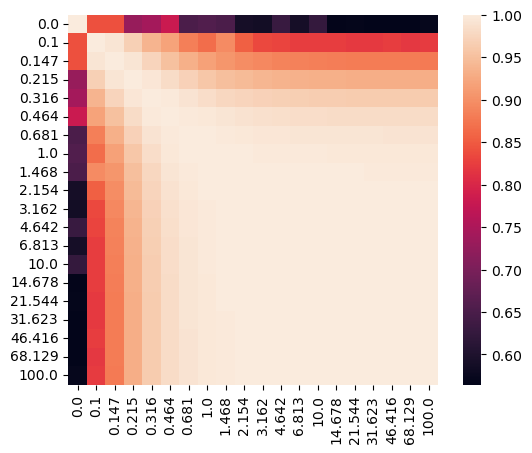

In [47]:
_lambda_list = [str(round(float(x), 3)) for x in sispca_auto.lambda_contrast_list]
_df = pd.DataFrame(
    sispca_auto.affinity_matrix, 
    columns=_lambda_list, 
    index=_lambda_list
)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(_df, annot=False, fmt=".2f", square = True)
plt.show()

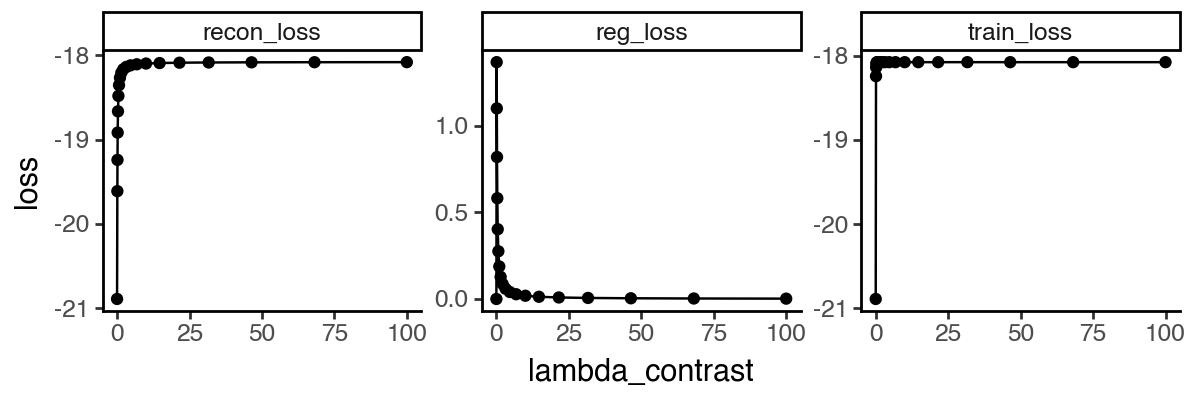

In [48]:
_df = pd.DataFrame(sispca_auto.final_loss[:]).melt(
    id_vars = 'lambda_contrast', var_name = 'loss_type', value_name = 'loss'
)

(
    ggplot(_df, aes(x = 'lambda_contrast', y = 'loss', group = 'loss_type')) + 
        facet_wrap('~loss_type', scales='free_y') +
        geom_line() + 
        geom_point() +
        theme_classic() + 
        theme(figure_size=(6,2))
)

From the above results, it appears that the optimal `lambda_contrast` is around 1, where the subspace representations become more stable and the loss curve starts to plateau. We can again visualize the changes of the individual subspaces.

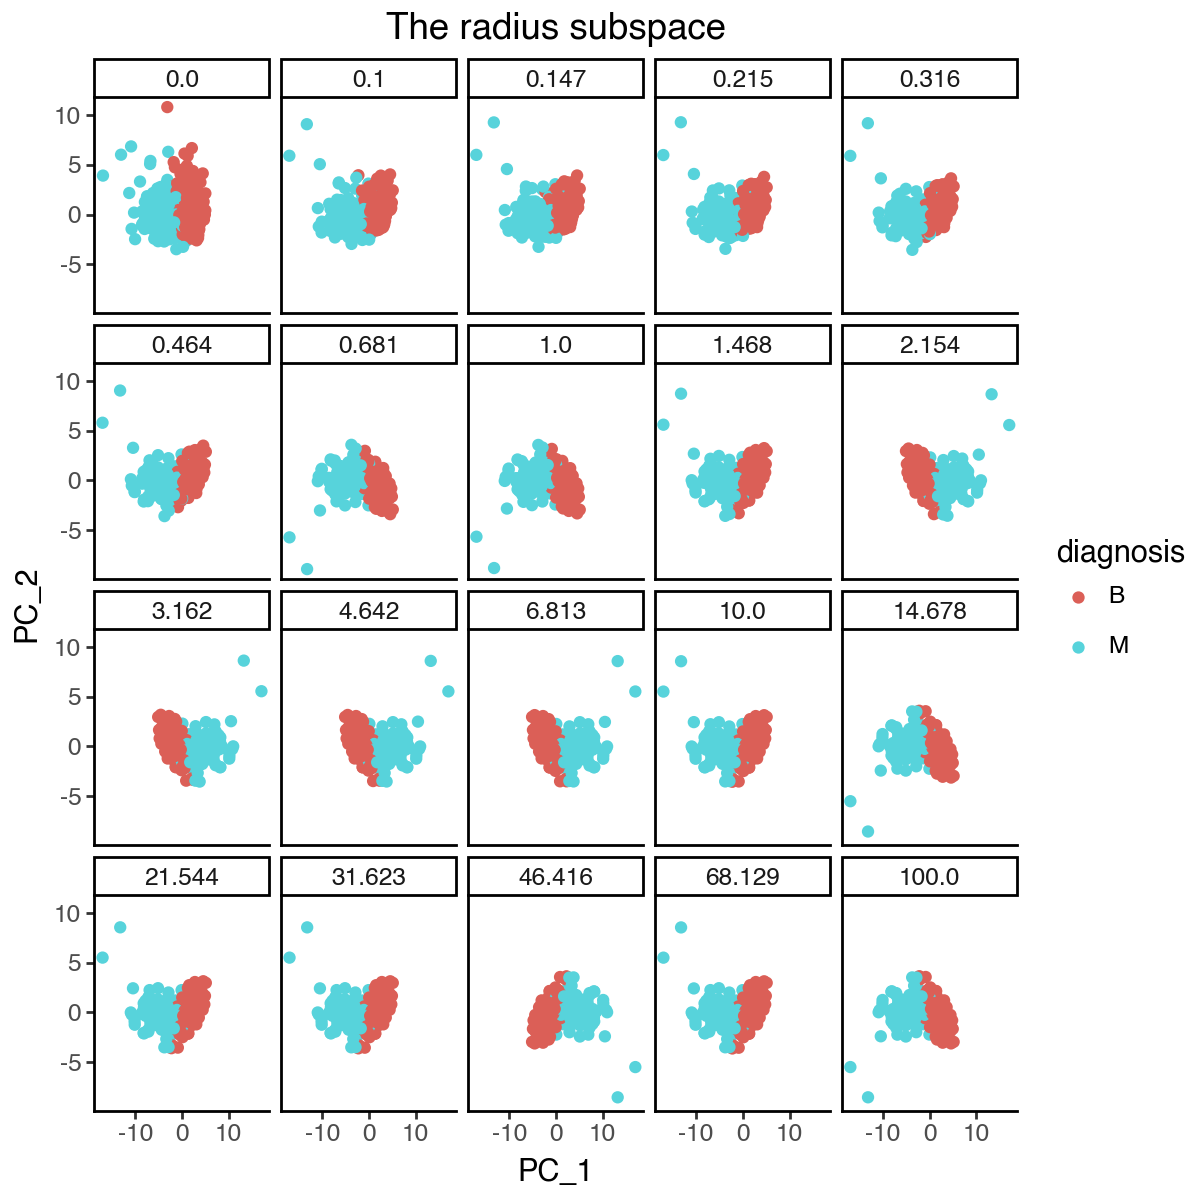

In [49]:
_df = pd.concat([
    pd.DataFrame(
        {'lambda_contrast': l, 
         'PC_1': m.get_latent_representation()[:, 0], 
         'PC_2': m.get_latent_representation()[:, 1],
         'diagnosis': data_raw['diagnosis']
        }
    )
    for l, m in zip(sispca_auto.lambda_contrast_list, sispca_auto.models)
])

(
    ggplot(_df, aes(x = 'PC_1', y = 'PC_2', color = 'diagnosis')) + 
        facet_wrap('~lambda_contrast', labeller=labeller(cols = lambda x: str(round(float(x), 3)))) +
        geom_point() +
        labs(title = 'The radius subspace') +
        theme_classic() + 
        theme(
            figure_size=(6,6),
            plot_background = element_rect(fill = 'white'),
        )
)

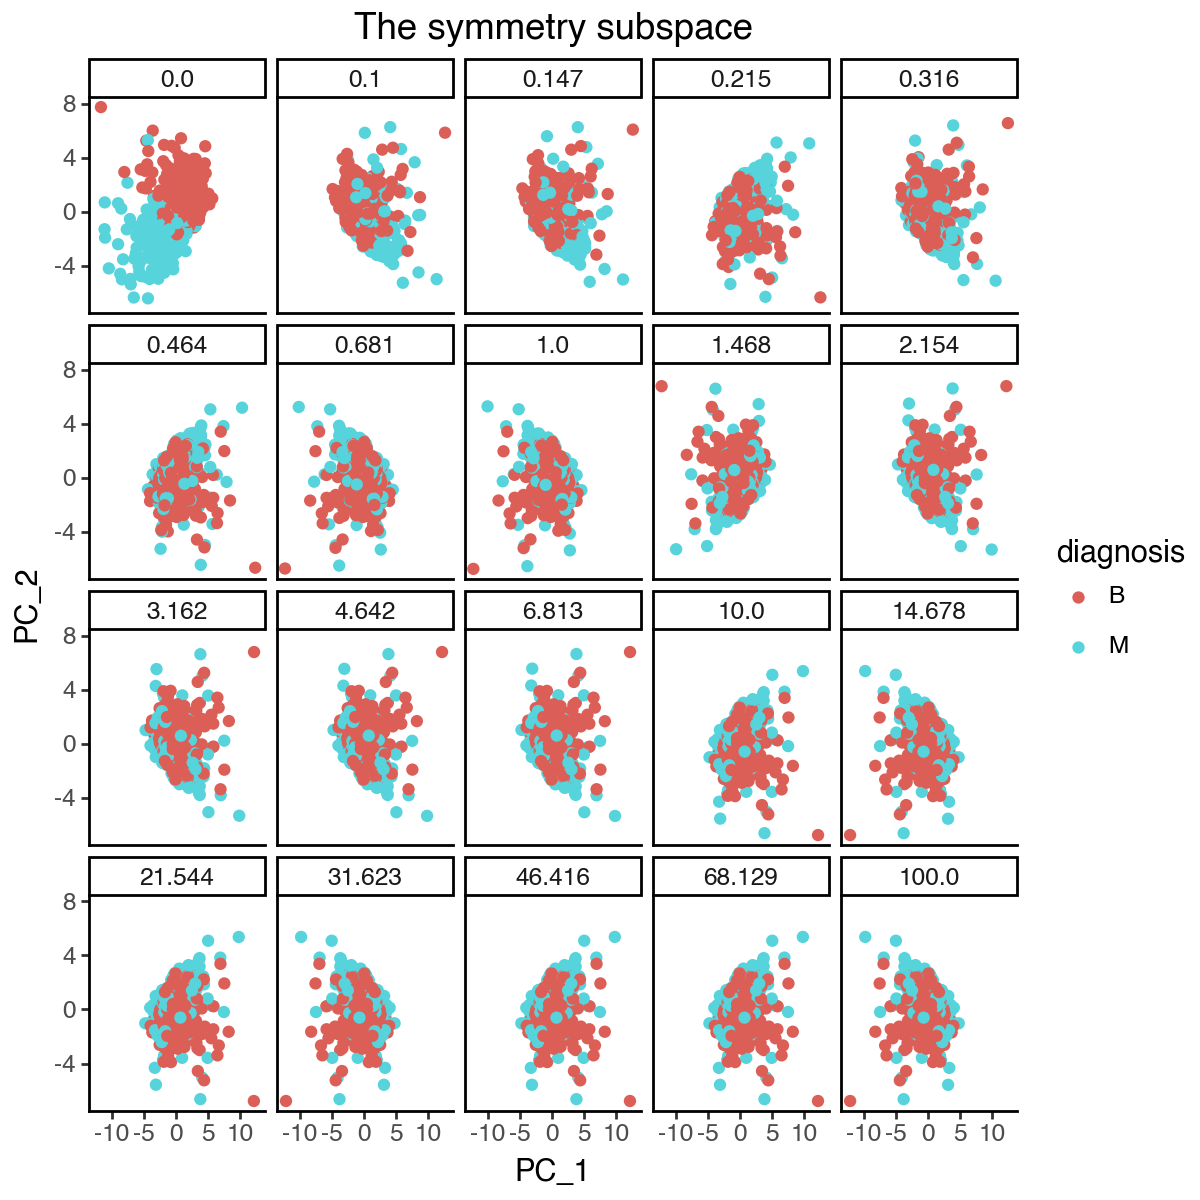

In [50]:
_df = pd.concat([
    pd.DataFrame(
        {'lambda_contrast': l, 
         'PC_1': m.get_latent_representation()[:, 3], 
         'PC_2': m.get_latent_representation()[:, 4],
         'diagnosis': data_raw['diagnosis']
        }
    )
    for l, m in zip(sispca_auto.lambda_contrast_list, sispca_auto.models)
])

(
    ggplot(_df, aes(x = 'PC_1', y = 'PC_2', color = 'diagnosis')) + 
        facet_wrap('~lambda_contrast', labeller=labeller(cols = lambda x: str(round(float(x), 3)))) +
        geom_point() +
        labs(title = 'The symmetry subspace') +
        theme_classic() + 
        theme(
            figure_size=(6,6),
            plot_background = element_rect(fill = 'white'),
        )
)